https://stackoverflow.com/questions/77587951/how-to-fit-a-system-of-odes-with-interpolation

In [28]:
import numpy as np
import numdifftools as nd
import matplotlib.pyplot as plt
from scipy import integrate, optimize, stats
from sklearn.metrics import r2_score

In [2]:
def system(t, x, k0, k1):
    return np.array([
        - k0 * x[0],
        + k0 * x[0] - k1 * x[1],
                    + k1 * x[1]
    ])

In [3]:
def solver(parameters, t=np.linspace(0, 1, 10)):
    solution = integrate.solve_ivp(
        system, [t.min(), t.max()], y0=parameters[-3:],
        args=parameters[:-3], t_eval=t
    )
    return solution.y

In [4]:
texp = np.linspace(0, 10, 30)
p0 = np.array([ 0.85, 0.15, 1.5, 0.25, 0.])

In [5]:
np.random.seed(12345)
xexp = solver(p0, t=texp)
sigma = 0.01 * np.ones_like(xexp) 
xexp += sigma * np.random.normal(size=xexp.shape)

In [6]:
def loss_factory(t, x, sigma):
    def wrapped(parameters):
        return 0.5 * np.sum(np.power((x - solver(parameters, t=t)) / sigma, 2))
    return wrapped

In [7]:
loss = loss_factory(texp, xexp, sigma)
solution = optimize.minimize(
    loss,
    x0=[1, 1, 1, 1, 1],
    bounds=[(0, np.inf)] * 5
)

In [8]:
solution

      fun: 41.60636573541066
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00301767, -0.01338876,  0.01562341,  0.01689315,  0.00656257])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 186
      nit: 27
     njev: 31
   status: 0
  success: True
        x: array([0.8364894 , 0.15044452, 1.5001996 , 0.24623917, 0.00241979])

In [18]:
xhat = solver(solution.x, t=texp)

In [25]:
score = r2_score(xexp, xhat)
score

0.999498540097489

In [45]:
chi2 = 2. * solution.fun  # 83.21273147082132
nu = xexp.size - p0.size  # 85
chi2n = chi2 / nu         # 0.9789733114214274

In [48]:
law  = stats.chi2(df=nu)
pvalue = law.sf(chi2)     # 0.5345849047291789
pvalue

0.5345849047291789

In [9]:
H = nd.Hessian(loss)(solution.x)

In [10]:
C = np.linalg.inv(H)

In [11]:
np.sqrt(np.diag(C))

array([0.00583539, 0.00059994, 0.00595627, 0.00643674, 0.00338883])

In [12]:
tlin = np.linspace(texp.min(), texp.max(), 200)
xhat = solver(solution.x, t=tlin)

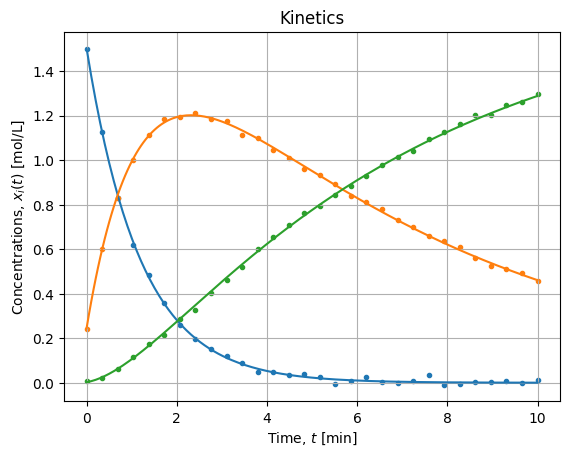

In [13]:
fig, axe = plt.subplots()
for i in range(xexp.shape[0]):
    axe.scatter(texp, xexp[i, :], marker=".")
    axe.plot(tlin, xhat[i, :])
axe.set_title(r"Kinetics")
axe.set_xlabel(r"Time, $t$ [min]")
axe.set_ylabel(r"Concentrations, $x_i(t)$ [mol/L]")
axe.grid()